# Mohamaco – Weekly Analysis

Reads `model_data.json` and renders:
- KPI dashboard (Revenue, Product Cost, Staff Cost, Net Profit, Net Margin)
- Impact: latest week vs previous week (totals + top movers)
- Staff cost breakdown (Department × Day)
- Ratios panel (sell-through, margin, DSI) for quick targeting

In [6]:
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
plt.style.use("ggplot")

md = pd.DataFrame(json.load(open("model_data.json","r",encoding="utf-8")))
VERSIONS = sorted(md["version"].unique())
V_NOW = VERSIONS[-1]; V_PREV = VERSIONS[-2] if len(VERSIONS)>1 else VERSIONS[-1]
print("Versions:", VERSIONS, "| Compare:", V_PREV, "→", V_NOW)

Versions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)] | Compare: 4 → 5


,version,qty,revenue,product_cost,gross_profit,staff_cost,net_profit,net_margin_%
0,0,20397.0,1444527.59,1061334.0,383193.59,194596.34,188597.25,13.06
1,1,20419.0,1053705.70,743237.0,310468.70,194596.34,115872.36,11.00
2,2,21353.0,801424.92,569282.0,232142.92,194596.34,37546.58,4.68
3,3,19187.0,1036064.91,748386.0,287678.91,194596.34,93082.57,8.98
4,4,29138.0,956008.62,668487.0,287521.62,194596.34,92925.28,9.72
5,5,30686.0,1533697.87,1088108.0,445589.87,194596.34,250993.53,16.37


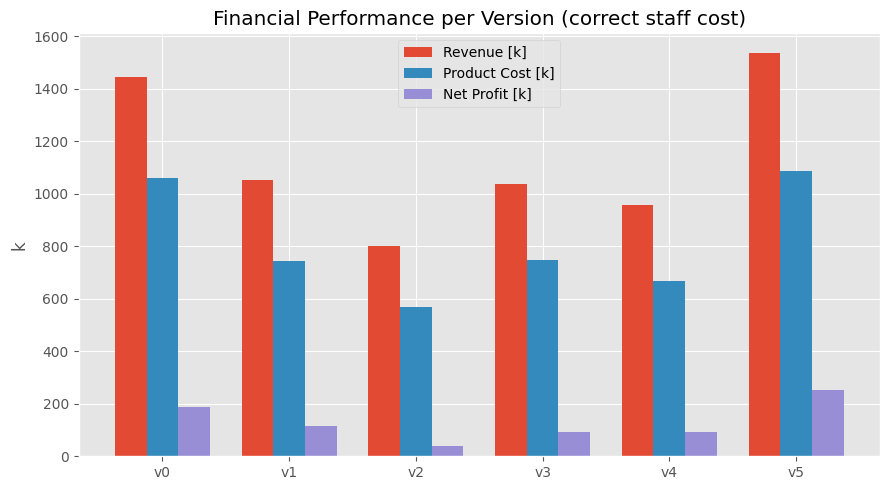

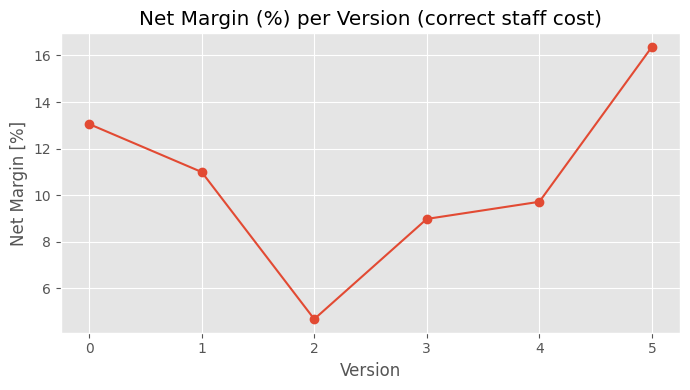

In [7]:
# KPI aggregation

# 1) Sum product-level metrics per version
sum_core = (
    md.groupby("version")[["qty","revenue","product_cost","gross_profit"]]
      .sum()
      .reset_index()
)

# 2) Take exactly one staff_cost per version (since it's duplicated per product)
#    Using max() (or first()) yields the single per-version staff cost you computed upstream.
staff_once = (
    md.groupby("version")["version_staff_cost"]
      .max()                # or .first()
      .rename("staff_cost")
      .reset_index()
)

# 3) Merge and compute net profit & margin
sumv = sum_core.merge(staff_once, on="version", how="left")
sumv["net_profit"]   = sumv["gross_profit"] - sumv["staff_cost"]
sumv["net_margin_%"] = np.where(sumv["revenue"] > 0,
                                sumv["net_profit"] / sumv["revenue"] * 100,
                                np.nan)

# 4) Sanity checks
assert (sumv["staff_cost"] >= 0).all(), "Staff cost should be non-negative"
display(sumv.round(2))

# 5) Plots
x = np.arange(len(sumv)); w = 0.25
fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x-w, sumv["revenue"]/1000, w, label="Revenue [k]")
ax.bar(x,   sumv["product_cost"]/1000, w, label="Product Cost [k]")
ax.bar(x+w, sumv["net_profit"]/1000, w, label="Net Profit [k]")
ax.set_xticks(x); ax.set_xticklabels([f"v{i}" for i in sumv["version"]])
ax.set_title("Financial Performance per Version (correct staff cost)")
ax.set_ylabel("k"); ax.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(sumv["version"], sumv["net_margin_%"], marker="o")
plt.title("Net Margin (%) per Version (correct staff cost)")
plt.xlabel("Version"); plt.ylabel("Net Margin [%]"); plt.tight_layout(); plt.show()


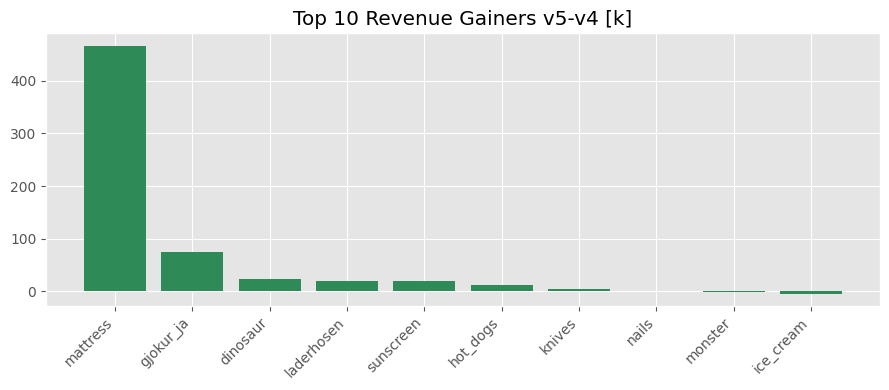

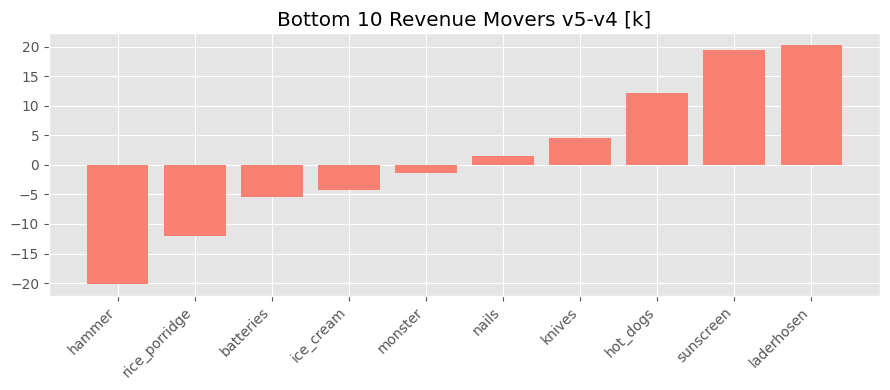

Totals:
Units: 29138 → 30686 (Δ +1548)
Revenue: 956.0k → 1533.7k (Δ +577.7k)
Gross Profit: 287.5k → 445.6k (Δ +158.1k)
Staff Cost: 2529.8k → 2529.8k (Δ +0.0k)
Net Profit: -2242.2k → -2084.2k (Δ +158.1k)


In [8]:
cur = md[md["version"]==V_NOW]; prev = md[md["version"]==V_PREV]
keep = ["product","amount","price","qty","revenue","gross_profit","supplier_price"]
gprev = prev[keep].groupby("product",as_index=False).sum()
gnow  = cur[keep].groupby("product",as_index=False).sum()
cmp = gnow.merge(gprev, on="product", suffixes=("_now","_prev"), how="outer").fillna(0.0)
cmp["price_delta_%"]=np.where(cmp["price_prev"]>0,(cmp["price_now"]-cmp["price_prev"])/cmp["price_prev"]*100,np.nan)
cmp["qty_delta"]=cmp["qty_now"]-cmp["qty_prev"]
cmp["revenue_delta"]=cmp["revenue_now"]-cmp["revenue_prev"]

topN=10
pos = cmp.sort_values("revenue_delta", ascending=False).head(topN)
neg = cmp.sort_values("revenue_delta", ascending=True).head(topN)

plt.figure(figsize=(9,4)); plt.bar(pos["product"], pos["revenue_delta"]/1000, color="seagreen")
plt.title(f"Top {topN} Revenue Gainers v{V_NOW}-v{V_PREV} [k]"); plt.xticks(rotation=45,ha="right"); plt.tight_layout(); plt.show()
plt.figure(figsize=(9,4)); plt.bar(neg["product"], neg["revenue_delta"]/1000, color="salmon")
plt.title(f"Bottom {topN} Revenue Movers v{V_NOW}-v{V_PREV} [k]"); plt.xticks(rotation=45,ha="right"); plt.tight_layout(); plt.show()

tprev = prev[["qty","revenue","gross_profit","version_staff_cost"]].sum()
tnow  = cur[["qty","revenue","gross_profit","version_staff_cost"]].sum()
print("Totals:")
print(f"Units: {tprev['qty']:.0f} → {tnow['qty']:.0f} (Δ {tnow['qty']-tprev['qty']:+.0f})")
print(f"Revenue: {tprev['revenue']/1000:.1f}k → {tnow['revenue']/1000:.1f}k (Δ {(tnow['revenue']-tprev['revenue'])/1000:+.1f}k)")
print(f"Gross Profit: {tprev['gross_profit']/1000:.1f}k → {tnow['gross_profit']/1000:.1f}k (Δ {(tnow['gross_profit']-tprev['gross_profit'])/1000:+.1f}k)")
print(f"Staff Cost: {tprev['version_staff_cost']/1000:.1f}k → {tnow['version_staff_cost']/1000:.1f}k (Δ {(tnow['version_staff_cost']-tprev['version_staff_cost'])/1000:+.1f}k)")
print(f"Net Profit: {(tprev['gross_profit']-tprev['version_staff_cost'])/1000:.1f}k → {(tnow['gross_profit']-tnow['version_staff_cost'])/1000:.1f}k (Δ {((tnow['gross_profit']-tnow['version_staff_cost'])-(tprev['gross_profit']-tprev['version_staff_cost']))/1000:+.1f}k)")

Staff cost by department (latest):


department
utilities    100636.98
registers     93959.35
Name: entry_cost, dtype: float64

Staff cost by day (latest):


day
friday       27799.48
monday       27799.48
saturday     27799.48
sunday       27799.48
thursday     27799.48
tuesday      27799.48
wednesday    27799.48
Name: entry_cost, dtype: float64

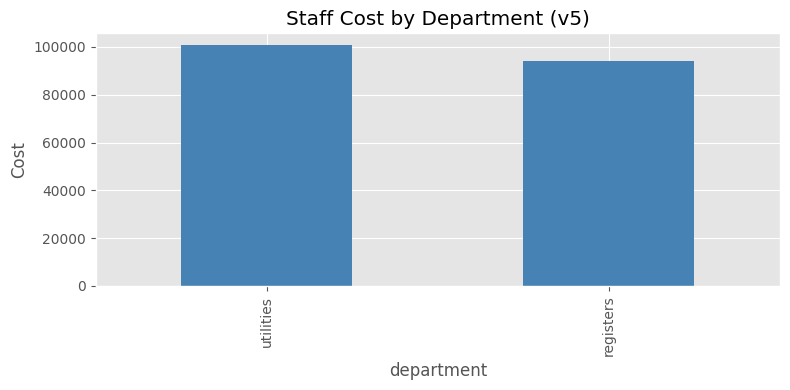

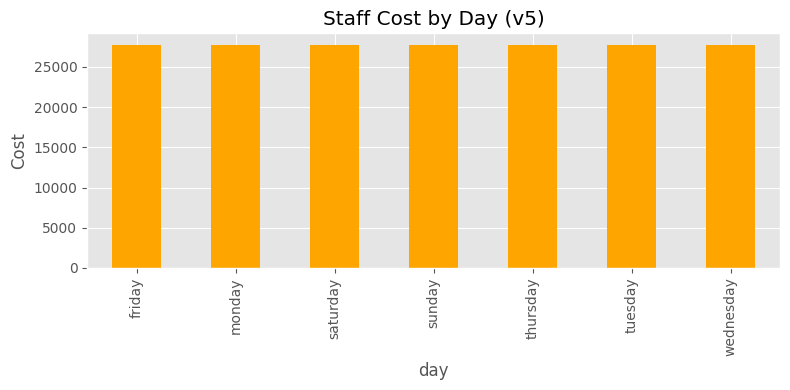

Staff cost matrix (day × department):


department,registers,utilities
day,,
friday,13422.76,14376.71
monday,13422.76,14376.71
saturday,13422.76,14376.71
sunday,13422.76,14376.71
thursday,13422.76,14376.71
tuesday,13422.76,14376.71
wednesday,13422.76,14376.71


In [9]:
# Needs schedules/workers again to split by department & day (model_data has totals only)
DATA_DIR = Path("data"); SCHEDULES_DIR = DATA_DIR/"schedules"; WORKERS_PATH = DATA_DIR/"workers"/"workers.jsonl"
def read_json(p): 
    with open(p,"r",encoding="utf-8") as f: return json.load(f)
def read_jsonl(p):
    rows=[]; 
    with open(p,"r",encoding="utf-8-sig") as f:
        for line in f:
            s=line.strip()
            if s: rows.append(json.loads(s))
    return pd.DataFrame(rows)

# flatten schedules for latest version
sched_raw = read_json(SCHEDULES_DIR/f"schedules_{V_NOW}.json")
rows=[]; 
for day, entries in sched_raw.items():
    for e in entries: rows.append({"day":day, **e})
sched = pd.DataFrame(rows)
if "worker_id" not in sched.columns:
    alt=[c for c in sched.columns if "worker" in c and "id" in c]
    if alt: sched=sched.rename(columns={alt[0]:"worker_id"})
sched["worker_id"]=sched["worker_id"].astype(str)
def shift_mult(x):
    try: 
        x=float(x); 
        return x if x>0 else 1.0
    except: return 1.0
sched["shift_mult"]=sched["shift"].apply(shift_mult) if "shift" in sched else 1.0

workers = read_jsonl(WORKERS_PATH)
if "worker_id" not in workers.columns:
    alt=[c for c in workers.columns if "worker" in c and "id" in c]
    if alt: workers=workers.rename(columns={alt[0]:"worker_id"})
workers["worker_id"]=workers["worker_id"].astype(str)
# derive per-shift cost from previous week (same logic as generator)
ref_v = VERSIONS[-2] if len(VERSIONS)>=2 else VERSIONS[-1]
# we need overall shifts_ref to compute per_shift_cost:
# Build a ref schedule quickly
def flatten_schedule(v):
    raw = read_json(SCHEDULES_DIR/f"schedules_{v}.json")
    rr=[]
    for day, entries in raw.items():
        for e in entries: rr.append({"day":day, **e})
    d=pd.DataFrame(rr); 
    if "worker_id" not in d.columns:
        alt=[c for c in d.columns if "worker" in c and "id" in c]
        if alt: d=d.rename(columns={alt[0]:"worker_id"})
    d["worker_id"]=d["worker_id"].astype(str)
    d["shift_mult"]=d["shift"].apply(shift_mult) if "shift" in d else 1.0
    return d

shifts_ref = flatten_schedule(ref_v).groupby("worker_id")["shift_mult"].sum().rename("shifts_ref")
workers = workers.merge(shifts_ref, on="worker_id", how="left").fillna({"shifts_ref":1.0})
workers["salary"]=pd.to_numeric(workers.get("salary", np.nan), errors="coerce")
workers["per_shift_cost"]=workers["salary"]/workers["shifts_ref"]

sched = sched.merge(workers[["worker_id","per_shift_cost"]], on="worker_id", how="left")
sched["entry_cost"]=sched["per_shift_cost"].fillna(0.0)*sched["shift_mult"].astype(float)

dept_cost = sched.groupby("department")["entry_cost"].sum().sort_values(ascending=False)
day_cost  = sched.groupby("day")["entry_cost"].sum().sort_index()

print("Staff cost by department (latest):"); display(dept_cost.round(2))
print("Staff cost by day (latest):"); display(day_cost.round(2))

plt.figure(figsize=(8,4)); dept_cost.plot(kind="bar", color="steelblue")
plt.title(f"Staff Cost by Department (v{V_NOW})"); plt.ylabel("Cost"); plt.tight_layout(); plt.show()
plt.figure(figsize=(8,4)); day_cost.plot(kind="bar", color="orange")
plt.title(f"Staff Cost by Day (v{V_NOW})"); plt.ylabel("Cost"); plt.tight_layout(); plt.show()

pivot = pd.pivot_table(sched, values="entry_cost", index="day", columns="department", aggfunc="sum", fill_value=0.0)
print("Staff cost matrix (day × department):"); display(pivot.round(2))

In [10]:
cur = md[md["version"]==V_NOW].copy()
cur["sell_through"]=np.divide(cur["qty"], cur["amount"], out=np.zeros_like(cur["qty"],float), where=cur["amount"]>0)
cur["price_cost_ratio"]=np.divide(cur["price"], cur["supplier_price"], out=np.zeros_like(cur["price"],float), where=cur["supplier_price"]>0)
cur["gross_margin_%"]=np.divide(cur["price"]-cur["supplier_price"], cur["price"], out=np.zeros_like(cur["price"],float), where=cur["price"]>0)*100
cur["demand_supply_index"]=cur["sell_through"]*cur["price_cost_ratio"]
display(cur.sort_values("demand_supply_index", ascending=False)[["product","qty","amount","price","revenue","sell_through","price_cost_ratio","gross_margin_%","demand_supply_index"]].head(12))

,product,qty,amount,price,revenue,sell_through,price_cost_ratio,gross_margin_%,demand_supply_index
67,gjokur_ja,100.0,100,893.63,89363.00,1.000000,1.540741,35.096181,1.540741
77,sunscreen,2999.0,2999,53.85,161496.15,1.000000,1.538571,35.004643,1.538571
69,hot_dogs,3004.0,3004,27.04,81228.16,1.000000,1.502222,33.431953,1.502222
75,nails,4152.0,4152,8.64,35873.28,1.000000,1.440000,30.555556,1.440000
76,rice_porridge,3745.0,3745,21.07,78907.15,1.000000,1.404667,28.808733,1.404667
70,ice_cream,3394.0,3394,11.00,37334.00,1.000000,1.375000,27.272727,1.375000
72,laderhosen,414.0,414,301.10,124655.40,1.000000,1.368636,26.934573,1.368636
65,batteries,3216.0,3216,16.33,52517.28,1.000000,1.360833,26.515615,1.360833
74,monster,3111.0,3111,21.57,67104.27,1.000000,1.348125,25.822902,1.348125
68,hammer,3415.0,3937,68.54,234064.10,0.867412,1.523111,34.344908,1.321164
